In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd

from random import random
from itertools import repeat

# In Serial

In [2]:
def serial_mean(lst):
    return sum(lst)/len(lst)
def serial_sd(lst, u=None):
    if u==None:
        u = serial_mean(lst)
    return sum([(x-u)**2 for x in lst])/(len(lst) - 1)

# In Parallel

### Parallel Mean

In [3]:
def parallel_mean1(lst, p):
    pool = mp.Pool(processes = p)
    l = len(lst)
    size = l//p + 1
    my_lst = [lst[i:i + size] for i in range(0, l, size)]
    my_lst = pool.map(sum, my_lst)
    pool.close()
    pool.join()
    return sum(my_lst)/len(lst)
    

In [4]:
def proc_sum3(args):
    lst, i, size = args[0], args[1], args[2]
    my_sum = 0
    for num in lst[i*size:(i+1)*size]:
        my_sum+= num
    return sum(lst[i*size:(i+1)*size])

def parallel_mean3(lst,p):
    manager = mp.Manager()
    shared_list = manager.list(lst)
    pool = mp.Pool(processes = p)
    l = len(lst)
    size = l//p + 1
    sums = pool.map(proc_sum3, [(shared_list, i,size) for i in range(p)])
    pool.close()
    pool.join()
    return sum(sums)/l

In [5]:
def proc_sum4(i, size, lst, ret_list):
    #lst, i, size = args[0], args[1], args[2]
    my_sum = 0
    for num in lst[i*size:(i+1)*size]:
        my_sum+= num
    ret_list[i] = sum(lst[i*size:(i+1)*size])
    return 

def parallel_mean4(lst,p):
    manager = mp.Manager()
    shared_list = manager.list(lst)
    ret_list = manager.list([0]*p)
    #pool = mp.Pool(processes = p)
    l = len(lst)
    size = l//p + 1
    jobs = [mp.Process(target=proc_sum4, args=(i, size, shared_list, ret_list)) for i in range(p)]
    #sums = pool.map(proc_sum, [(shared_list, i,size) for i in range(p)])
    for job in jobs: job.start()
    for job in jobs: job.join()
    return sum(ret_list)/l

In [6]:
def proc_sum5(args):
    lst, i, size = args[0], args[1], args[2]
    my_sum = 0
    for num in lst[i*size:(i+1)*size]:
        my_sum+= num
    return sum(lst[i*size:(i+1)*size])

def parallel_mean5(lst,p):
    manager = mp.Manager()
    shared_list = manager.Array('f',lst)
    pool = mp.Pool(processes = p)
    l = len(lst)
    size = l//p + 1
    sums = pool.map(proc_sum3, [(shared_list, i,size) for i in range(p)])
    pool.close()
    pool.join()
    return sum(sums)/l

In [7]:
def proc_sum6(i, size, lst, ret_list):
    ret_list[i] = sum(lst[i*size:(i+1)*size])
    return 

def parallel_mean6(lst,p):
    manager = mp.Manager()
    shared_list = manager.list(lst)
    ret_list = manager.list([0]*p)
    #pool = mp.Pool(processes = p)
    l = len(lst)
    size = l//p + 1
    jobs = [mp.Process(target=proc_sum6, args=(i, size, shared_list, ret_list)) for i in range(p)]
    #sums = pool.map(proc_sum, [(shared_list, i,size) for i in range(p)])
    for job in jobs: job.start()
    for job in jobs: job.join()
    return sum(ret_list)/l

parallel_mean = parallel_mean6

### Parallel Mean Testings

In [17]:
N = 10**4
lst = [random() for i in range(N)]
u_serial = serial_mean(lst)
p = mp.cpu_count()

In [18]:
%%timeit
parallel_mean1(lst,p)

10 loops, best of 3: 159 ms per loop


In [20]:
%%timeit
parallel_mean3(lst,p)

10 loops, best of 3: 181 ms per loop


In [21]:
%%timeit
parallel_mean4(lst,p)

10 loops, best of 3: 88.5 ms per loop


In [22]:
%%timeit
parallel_mean5(lst,p)

10 loops, best of 3: 180 ms per loop


In [23]:
%%timeit
parallel_mean6(lst,p)

10 loops, best of 3: 86.6 ms per loop


### Mean Verifications

In [8]:
N = 10**4
tolerance = 10**-8

p = mp.cpu_count()
lst = [random() for i in range(N)]
u_serial = serial_mean(lst)
assert u_serial - parallel_mean1(lst,p) < tolerance
assert u_serial - parallel_mean3(lst,p) < tolerance
assert u_serial - parallel_mean4(lst,p) < tolerance
assert u_serial - parallel_mean5(lst,p) < tolerance
assert u_serial - parallel_mean6(lst,p) < tolerance

### Parallel Standard Deviation

In [9]:
def proc_sd(i, u, size, lst, ret_list):
    ret_list[i] = sum([ (x-u)**2  for x in lst[i*size:(i+1)*size] ])
    return

def parallel_sd(lst,p, u=None):
    if u == None:
        u = parallel_mean(lst,p)
        
    manager = mp.Manager()
    shared_list = manager.list(lst)
    ret_list = manager.list([0]*p)
    l = len(lst)
    size = l//p + 1
    jobs = [mp.Process(target=proc_sd, args=(i, u, size, shared_list, ret_list)) for i in range(p)]
    for job in jobs: job.start()
    for job in jobs: job.join()
    return sum(ret_list)/(l-1)

### Standard Deviation Verification

In [10]:
N = 10**4
tolerance = 10**-8

p = mp.cpu_count()
lst = [random() for i in range(N)]

sd_serial = serial_sd(lst)
assert sd_serial - parallel_sd(lst,1) < tolerance

# Times

In [67]:
N = 10**6
lst = [random() for i in range(N)]

columns = ['Time', 'Processors', 'Speed-Up', 'Efficiency', 'Theoretical Speed-Up', 'Theoretical Efficiency']
mean_data = pd.DataFrame(columns=columns)
sd_data = pd.DataFrame(columns=columns)

In [68]:
def stats_from_timeit(timeit_result, num_proc, description):
    t = timeit_result.best
    data_row = {'Time': t, 'Processors': num_proc}
    return pd.Series(data=data_row, name=description)

In [69]:
my_time = %timeit -o w = serial_mean(lst)
mean_data = mean_data.append(stats_from_timeit(my_time, 1, 'Serial'))
T0 = my_time.best

100 loops, best of 3: 6.61 ms per loop


In [70]:
process_counts = range(0, int(np.log(mp.cpu_count())/np.log(2))+3)
process_counts = [2**p for p in process_counts]

for p in process_counts:
    my_time = %timeit -o w = parallel_mean(lst,p)
    mean_data = mean_data.append(stats_from_timeit(my_time, p, 'Parallel'))

1 loop, best of 3: 469 ms per loop
1 loop, best of 3: 463 ms per loop
1 loop, best of 3: 513 ms per loop
1 loop, best of 3: 696 ms per loop
1 loop, best of 3: 1.07 s per loop
1 loop, best of 3: 1.85 s per loop
1 loop, best of 3: 3.41 s per loop


In [71]:
mean_data['Speed-Up'] = T0/mean_data['Time']
mean_data['Efficiency'] = mean_data['Speed-Up']/mean_data['Processors']
mean_data['Theoretical Speed-Up'] = mean_data['Processors']
mean_data['Theoretical Efficiency'] = 1

In [72]:
mean_data

,Time,Processors,Speed-Up,Efficiency,Theoretical Speed-Up,Theoretical Efficiency
Serial,0.006607,1.0,1.000000,1.000000,1.0,1
Parallel,0.468722,1.0,0.014095,0.014095,1.0,1
Parallel,0.463141,2.0,0.014265,0.007133,2.0,1
Parallel,0.513400,4.0,0.012869,0.003217,4.0,1
Parallel,0.695732,8.0,0.009496,0.001187,8.0,1
Parallel,1.072743,16.0,0.006159,0.000385,16.0,1
Parallel,1.849156,32.0,0.003573,0.000112,32.0,1
Parallel,3.414265,64.0,0.001935,0.000030,64.0,1


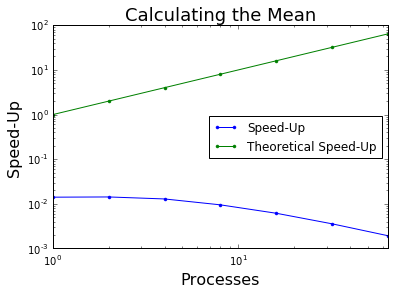

In [73]:
parallel_data = mean_data.loc['Parallel'][['Processors','Speed-Up','Theoretical Speed-Up']]
plt = parallel_data.plot(x='Processors',style='.-', loglog=True)
plt.set_title('Calculating the Mean',fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Speed-Up',fontsize=16);

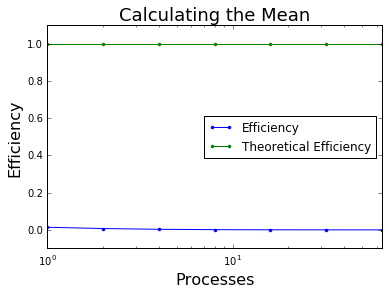

In [87]:
parallel_data = mean_data.loc['Parallel'][['Processors','Efficiency','Theoretical Efficiency']]
plt = parallel_data.plot(x='Processors',style='.-', logx=True)
plt.set_title("Calculating the Mean",fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Efficiency',fontsize=16);
plt.set_ylim(-0.1, 1.1);

In [75]:
my_time = %timeit -o w = serial_sd(lst)
sd_data = sd_data.append(stats_from_timeit(my_time, 1, 'Serial'))
T0 = my_time.best

1 loop, best of 3: 207 ms per loop


In [76]:
process_counts = range(0, int(np.log(mp.cpu_count())/np.log(2))+3)
process_counts = [2**p for p in process_counts]

for p in process_counts:
    my_time = %timeit -o w = parallel_sd(lst,p)
    sd_data = sd_data.append(stats_from_timeit(my_time, p, 'Parallel'))

1 loop, best of 3: 1.13 s per loop
1 loop, best of 3: 1.01 s per loop
1 loop, best of 3: 1.07 s per loop
1 loop, best of 3: 1.42 s per loop
1 loop, best of 3: 2.15 s per loop
1 loop, best of 3: 3.78 s per loop
1 loop, best of 3: 6.83 s per loop


In [79]:
sd_data['Speed-Up'] = T0/sd_data['Time']
sd_data['Efficiency'] = sd_data['Speed-Up']/sd_data['Processors']
sd_data['Theoretical Speed-Up'] = sd_data['Processors']
sd_data['Theoretical Efficiency'] = 1
sd_data

,Time,Processors,Speed-Up,Efficiency,Theoretical Speed-Up,Theoretical Efficiency
Serial,0.206555,1.0,1.000000,1.000000,1.0,1
Parallel,1.130122,1.0,0.182773,0.182773,1.0,1
Parallel,1.005594,2.0,0.205406,0.102703,2.0,1
Parallel,1.074091,4.0,0.192307,0.048077,4.0,1
Parallel,1.416384,8.0,0.145833,0.018229,8.0,1
Parallel,2.149617,16.0,0.096089,0.006006,16.0,1
Parallel,3.778874,32.0,0.054661,0.001708,32.0,1
Parallel,6.833995,64.0,0.030225,0.000472,64.0,1


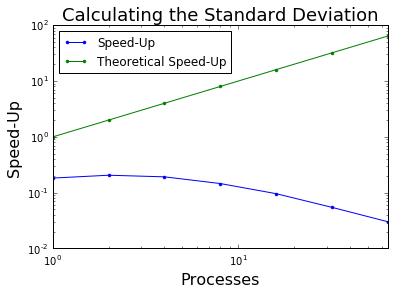

In [80]:
parallel_data = sd_data.loc['Parallel'][['Processors','Speed-Up','Theoretical Speed-Up']]
plt = parallel_data.plot(x='Processors',style='.-', loglog=True)
plt.set_title('Calculating the Standard Deviation',fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Speed-Up',fontsize=16);

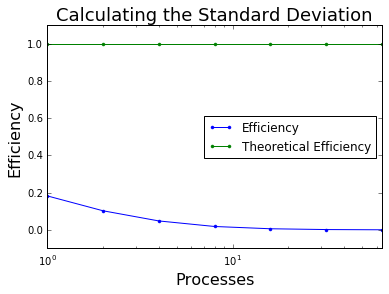

In [86]:
parallel_data = sd_data.loc['Parallel'][['Processors','Efficiency','Theoretical Efficiency']]
plt = parallel_data.plot(x='Processors',style='.-', logx=True)
plt.set_title("Calculating the Standard Deviation",fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Efficiency',fontsize=16);
plt.set_ylim(-0.1, 1.1);

# Analysis

These parallelized algorithms are horrible!!!

They are so much slower than performing the calculation in serial. The more processes are allocated, the longer it takes - the exact opposite expected when parallelizing computations. While these processes were running, I was watching the cpu load per core using $\textbf{top}$ - a linux program for monitoring system processes. Regardless of the size of the list, there would be long periods where only one core was being used followed by short bursts where more cores were used. It appears that these implementations spend much more time dividing up the list than they do actually calculating the values. 

We can test this by pre-splitting the list.

In [51]:
def proc_sum_divided(i, lst,ret_list):
    ret_list[i] = sum(lst)
    return 

def parallel_mean_divided(lists):
    manager = mp.Manager()
    ret_list = manager.list([0]*len(lists))
    jobs = [mp.Process(target=proc_sum_divided, args=(i, lst, ret_list) ) for i, lst in enumerate(lists)]
    for job in jobs: job.start()
    for job in jobs: job.join()
    return sum(ret_list)/sum([len(lst) for lst in lists])

In [52]:
N = 2 * 10**8
lst = [random() for i in range(N)]

columns = ['Time', 'Processors', 'Speed-Up', 'Efficiency', 'Theoretical Speed-Up', 'Theoretical Efficiency']
divided_data = pd.DataFrame(columns=columns)

In [53]:
my_time = %timeit -o w = serial_mean(lst)
divided_data = divided_data.append(stats_from_timeit(my_time, 1, 'Serial'))
T0 = my_time.best

1 loop, best of 3: 1.35 s per loop


In [54]:
process_counts = range(0, int(np.log(mp.cpu_count())/np.log(2))+3)
process_counts = [2**p for p in process_counts]

for p in process_counts:
    l = len(lst)
    size = l//p + 1
    lists = [lst[i*size:(i+1)*size] for i in range(p)]
    my_time = %timeit -o w = parallel_mean_divided(lists)
    divided_data = divided_data.append(stats_from_timeit(my_time, p, 'Parallel'))

1 loop, best of 3: 5.13 s per loop
1 loop, best of 3: 2.84 s per loop
1 loop, best of 3: 1.81 s per loop
1 loop, best of 3: 1.58 s per loop
1 loop, best of 3: 1.93 s per loop
1 loop, best of 3: 3.07 s per loop
1 loop, best of 3: 5.68 s per loop


In [55]:
divided_data['Speed-Up'] = T0/divided_data['Time']
divided_data['Efficiency'] = divided_data['Speed-Up']/divided_data['Processors']
divided_data['Theoretical Speed-Up'] = divided_data['Processors']
divided_data['Theoretical Efficiency'] = 1
divided_data

,Time,Processors,Speed-Up,Efficiency,Theoretical Speed-Up,Theoretical Efficiency
Serial,1.352432,1.0,1.000000,1.000000,1.0,1
Parallel,5.130235,1.0,0.263620,0.263620,1.0,1
Parallel,2.843898,2.0,0.475556,0.237778,2.0,1
Parallel,1.813617,4.0,0.745709,0.186427,4.0,1
Parallel,1.583323,8.0,0.854173,0.106772,8.0,1
Parallel,1.928213,16.0,0.701391,0.043837,16.0,1
Parallel,3.074654,32.0,0.439865,0.013746,32.0,1
Parallel,5.678622,64.0,0.238162,0.003721,64.0,1


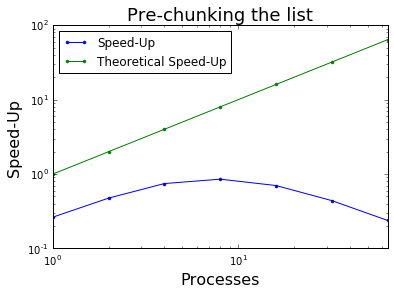

In [56]:
parallel_data = divided_data.loc['Parallel'][['Processors','Speed-Up','Theoretical Speed-Up']]
plt = parallel_data.plot(x='Processors',style='.-', loglog=True)
plt.set_title('Pre-chunking the list',fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Speed-Up',fontsize=16);

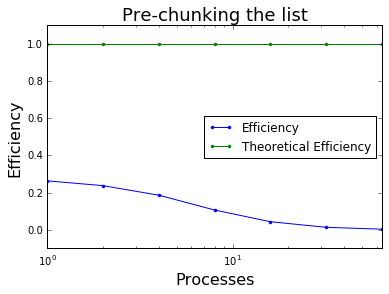

In [57]:
parallel_data = divided_data.loc['Parallel'][['Processors','Efficiency','Theoretical Efficiency']]
plt = parallel_data.plot(x='Processors',style='.-', logx=True)
plt.set_title("Pre-chunking the list",fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Efficiency',fontsize=16);
plt.set_ylim(-0.1, 1.1);

These results weekly support the hypothesis in that they do show much more improvement as the number of cores goes up, but they are still laughably slower than the simple way of performing the calculations in serial. 

# Calculating the Median

In [85]:
N = 10**5
lst = [random() for i in range(N)]

In [86]:
def median_serial_sort(lst):
    return sorted(lst)[N//2]

In [87]:
print(median_serial_sort(lst))

0.49902855648716693
